In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/final-data-boosting/final_data.csv


In [3]:
df = pd.read_csv("/kaggle/input/final-data-boosting/final_data.csv")

In [4]:
df.shape

(11580, 88)

In [5]:
list_col = []
for col in df.columns:
    list_col.append(col)

In [6]:
list_col

['personid',
 'encounterid',
 'gender',
 'race',
 'ethnicity',
 'effectivedate',
 'asserteddate',
 'source_encounter_type',
 'conditioncodes',
 'servicedate',
 'hospitalizationstartdate',
 'dischargedate',
 'encountertype',
 'age_at_encounter',
 'payer',
 'admissiontype',
 'dischargedisposition',
 'cvd_dx_ind',
 'pos_cvd_lab_ind',
 'pos_lab_2wk_prior_ind',
 'enc_cvd_lab_recs',
 'pat_cvd_lab_recs',
 'enc_dx_recs',
 'hist_dx_recs',
 'enc_px_recs',
 'enc_med_recs',
 'enc_result_recs',
 'numDiagnosis',
 'Diagnosis1',
 'Diagnosis2',
 'Diagnosis3',
 'Diagnosis4',
 'Diagnosis5',
 'Diagnosis6',
 'Diagnosis7',
 'Diagnosis8',
 'Diagnosis9',
 'Diagnosis10',
 'Diagnosis11',
 'Diagnosis12',
 'Diagnosis13',
 'Diagnosis14',
 'Diagnosis15',
 'Diagnosis16',
 'Diagnosis17',
 'Diagnosis18',
 'Diagnosis19',
 'Diagnosis20',
 'Diagnosis21',
 'Diagnosis22',
 'Diagnosis23',
 'Diagnosis24',
 'Diagnosis25',
 'Diagnosis26',
 'Diagnosis27',
 'Diagnosis28',
 'Diagnosis29',
 'Diagnosis30',
 'Diagnosis31',
 'A',
 'B

In [7]:
# Filter out columns that contain 'date' in their names
date_columns = [col for col in df.columns if 'date' in col]
df_filtered = df.drop(columns=date_columns)

# Define a list of post-admission columns to be removed
post_admission_columns = [
    'dischargedate', 'dischargedisposition', 
    'enc_cvd_lab_recs', 'pat_cvd_lab_recs', 'enc_dx_recs', 
    'enc_result_recs', 'enc_med_recs', 'enc_px_recs', 'LoS', 'LoService'
]

# Remove post-admission columns that are also in the DataFrame
post_admission_columns = [col for col in post_admission_columns if col in df_filtered.columns]
df_filtered = df_filtered.drop(columns=post_admission_columns)

# Now df_filtered should contain only the columns you need at the time of admission
print(df_filtered.columns)

Index(['personid', 'encounterid', 'gender', 'race', 'ethnicity',
       'source_encounter_type', 'conditioncodes', 'encountertype',
       'age_at_encounter', 'payer', 'admissiontype', 'cvd_dx_ind',
       'pos_cvd_lab_ind', 'pos_lab_2wk_prior_ind', 'hist_dx_recs',
       'numDiagnosis', 'Diagnosis1', 'Diagnosis2', 'Diagnosis3', 'Diagnosis4',
       'Diagnosis5', 'Diagnosis6', 'Diagnosis7', 'Diagnosis8', 'Diagnosis9',
       'Diagnosis10', 'Diagnosis11', 'Diagnosis12', 'Diagnosis13',
       'Diagnosis14', 'Diagnosis15', 'Diagnosis16', 'Diagnosis17',
       'Diagnosis18', 'Diagnosis19', 'Diagnosis20', 'Diagnosis21',
       'Diagnosis22', 'Diagnosis23', 'Diagnosis24', 'Diagnosis25',
       'Diagnosis26', 'Diagnosis27', 'Diagnosis28', 'Diagnosis29',
       'Diagnosis30', 'Diagnosis31', 'A', 'B', 'AB', 'C', 'D1', 'D2', 'E', 'F',
       'G', 'H1', 'H2', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S',
       'Z', 'Gender_recoded', 'Race_recoded', 'deceased', 'route'],
      dtype='obj

In [8]:
df_filtered['route']

0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
11575     1.0
11576    35.0
11577     1.0
11578     1.0
11579    35.0
Name: route, Length: 11580, dtype: float64

In [9]:
df_filtered.shape

(11580, 74)

In [10]:
pip install xgboost shap matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [11]:
# Define the threshold for removing columns
threshold = 0.7

# Calculate the percentage of missing values per column
missing_percentage = df_filtered.isnull().mean()

# Filter out columns exceeding the threshold
columns_to_drop = missing_percentage[missing_percentage > threshold].index

# Drop these columns from the DataFrame
df_cleaned = df_filtered.drop(columns=columns_to_drop)

In [12]:
from scipy.stats import chi2

def little_mcar_test(data, alpha=0.05):
    """
    Performs Little's MCAR (Missing Completely At Random) test on a dataset with missing values.
    """
    data = pd.DataFrame(data)
    data.columns = ['x' + str(i) for i in range(data.shape[1])]
    data['missing'] = np.sum(data.isnull(), axis=1)
    n = data.shape[0]
    k = data.shape[1] - 1
    df = k * (k - 1) / 2
    chi2_crit = chi2.ppf(1 - alpha, df)
    chi2_val = ((n - 1 - (k - 1) / 2) ** 2) / (k - 1) / ((n - k) * np.mean(data['missing']))
    p_val = 1 - chi2.cdf(chi2_val, df)
    if chi2_val > chi2_crit:
        print(
            'Reject null hypothesis: Data is not MCAR (p-value={:.4f}, chi-square={:.4f})'.format(p_val, chi2_val)
        )
    else:
        print(
            'Do not reject null hypothesis: Data is MCAR (p-value={:.4f}, chi-square={:.4f})'.format(p_val, chi2_val)
        )

In [13]:
little_mcar_test(df_cleaned)

Do not reject null hypothesis: Data is MCAR (p-value=1.0000, chi-square=39.0843)


# Filling the missing values with KNN imputaiton

In [14]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

# Assuming df_cleaned is already defined

# Step 1: Encode categorical columns using LabelEncoder
label_encoders = {}
cat_cols = df_cleaned.select_dtypes(include=['object']).columns.tolist()

for col in cat_cols:
    le = LabelEncoder()
    df_cleaned[col] = le.fit_transform(df_cleaned[col].astype(str))
    label_encoders[col] = le

# Intermediate check: Ensure encoding is correct
print("Encoded DataFrame:")
print(df_cleaned.head())

# Step 2: Impute missing values using KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(knn_imputer.fit_transform(df_cleaned), columns=df_cleaned.columns)

# Show the imputed DataFrame
print("Imputed DataFrame:")
print(df_imputed.head())

Encoded DataFrame:
   personid  encounterid  gender  race  ethnicity  source_encounter_type  \
0         0         2468       1     2          2                      0   
1         1         5369       1     6          1                      0   
2         2        10952       0     6          2                      0   
3         3          608       1     1          2                      0   
4         3         8258       1     1          2                      0   

   conditioncodes  encountertype  age_at_encounter  payer  ...  O  P  Q  R  S  \
0            3525              1                54      6  ...  0  0  0  0  0   
1            2064              1                31     22  ...  0  0  0  1  0   
2            7666              2                89     13  ...  0  0  0  1  0   
3            7218              2                67      6  ...  0  0  0  1  1   
4            3831              1                67     19  ...  0  0  0  1  0   

   Z  Gender_recoded  Race_recoded  d

In [15]:
# Check for missing values in df_imputed
missing_values = df_imputed.isnull().sum()

# Display columns with missing values
missing_columns = missing_values[missing_values > 0]
if missing_columns.empty:
    print("No missing values are present in df_imputed.")
else:
    print("Columns with missing values:")
    print(missing_columns)

No missing values are present in df_imputed.


In [16]:
df_imputed.shape

(11580, 56)

In [17]:
df_cleaned = df_imputed

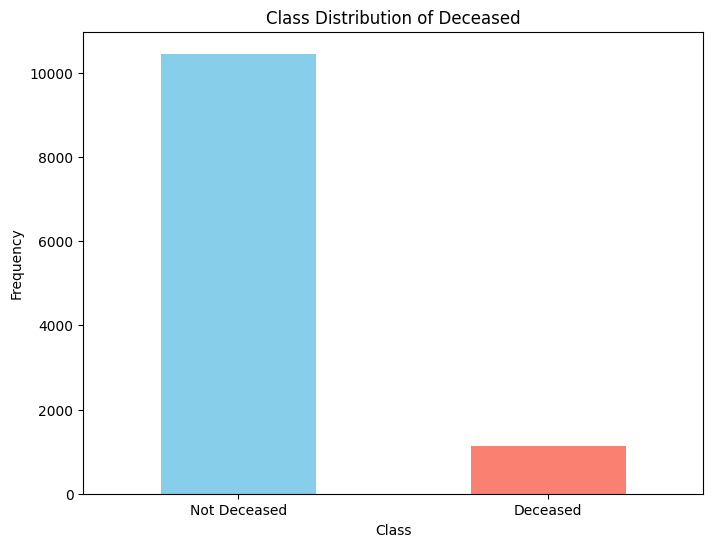

In [19]:
# Plotting the imbalance in the 'deceased' column
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
df_cleaned['deceased'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution of Deceased')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1], labels=['Not Deceased', 'Deceased'], rotation=0)
plt.show()

# Now combination of undersampling of nmajority class and oversampling of minority class so that the target variable becomes balanced

In [20]:
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter

# Assuming df_imputed is your DataFrame and 'target' is the target variable

# Define the target variable
target = 'deceased'

# Separate features and target
X = df_cleaned.drop(columns=[target])
y = df_cleaned[target]

# Check initial class distribution
print('Original dataset shape:', Counter(y))

# Step 1: Undersample the majority class
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)  # Adjust the strategy as needed
X_res, y_res = rus.fit_resample(X, y)
print('After undersampling:', Counter(y_res))

# Step 2: Oversample the minority class using SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_res, y_res = smote.fit_resample(X_res, y_res)
print('After oversampling:', Counter(y_res))

# Combine the resampled features and target into a single DataFrame
df_balanced = pd.DataFrame(X_res, columns=X.columns)
df_balanced[target] = y_res

# Display the balanced DataFrame
print("Balanced DataFrame:")
print(df_balanced.head())

Original dataset shape: Counter({0.0: 10451, 1.0: 1129})
After undersampling: Counter({0.0: 2258, 1.0: 1129})
After oversampling: Counter({0.0: 2258, 1.0: 2258})
Balanced DataFrame:
   personid  encounterid  gender  race  ethnicity  source_encounter_type  \
0    5862.0       9884.0     1.0   4.0        0.0                    0.0   
1    5032.0       4340.0     1.0   2.0        2.0                    0.0   
2    3033.0       9573.0     0.0   6.0        2.0                    0.0   
3    3457.0       1189.0     0.0   2.0        2.0                    0.0   
4    2751.0       6955.0     1.0   6.0        2.0                    0.0   

   conditioncodes  encountertype  age_at_encounter  payer  ...    O    P    Q  \
0          8363.0            2.0              60.0   22.0  ...  0.0  0.0  0.0   
1          8939.0            2.0              52.0    6.0  ...  0.0  0.0  0.0   
2          2585.0            2.0              69.0    6.0  ...  0.0  0.0  0.0   
3           250.0            2.0     

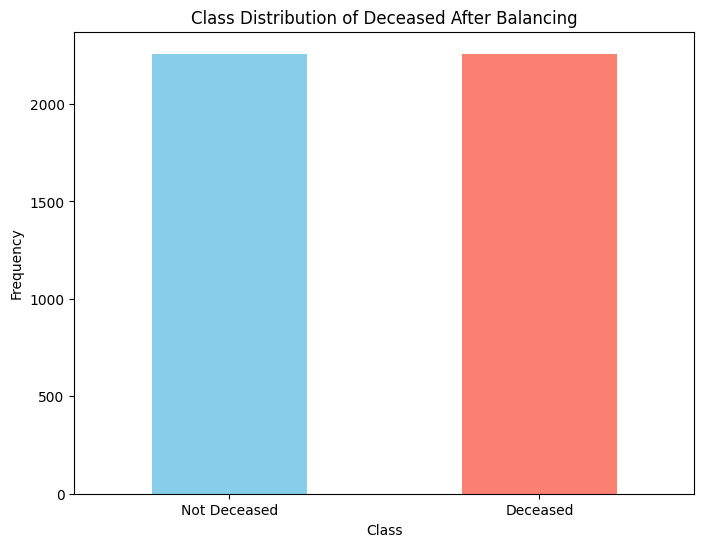

In [21]:
import matplotlib.pyplot as plt

# Plotting the imbalance in the 'deceased' column in the balanced DataFrame
plt.figure(figsize=(8, 6))
df_balanced['deceased'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution of Deceased After Balancing')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1], labels=['Not Deceased', 'Deceased'], rotation=0)
plt.show()

# SHAP BEFORE ONE-HOT ENCODING

In [22]:
df_cleaned = df_balanced

In [23]:
df_cleaned.columns

Index(['personid', 'encounterid', 'gender', 'race', 'ethnicity',
       'source_encounter_type', 'conditioncodes', 'encountertype',
       'age_at_encounter', 'payer', 'admissiontype', 'cvd_dx_ind',
       'pos_cvd_lab_ind', 'hist_dx_recs', 'numDiagnosis', 'Diagnosis1',
       'Diagnosis2', 'Diagnosis3', 'Diagnosis4', 'Diagnosis5', 'Diagnosis6',
       'Diagnosis7', 'Diagnosis8', 'Diagnosis9', 'Diagnosis10', 'Diagnosis11',
       'Diagnosis12', 'Diagnosis13', 'Diagnosis14', 'A', 'B', 'AB', 'C', 'D1',
       'D2', 'E', 'F', 'G', 'H1', 'H2', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P',
       'Q', 'R', 'S', 'Z', 'Gender_recoded', 'Race_recoded', 'route',
       'deceased'],
      dtype='object')

In [24]:
import pandas as pd

# Assuming df_cleaned is your DataFrame
# Filter out columns that contain 'id' in their names
id_columns = [col for col in df_cleaned.columns if 'id' in col.lower()]
df_filtered = df_cleaned.drop(columns=id_columns)

# Now df_filtered is your DataFrame without the columns containing 'id'
print(df_filtered.columns)

Index(['gender', 'race', 'ethnicity', 'source_encounter_type',
       'conditioncodes', 'encountertype', 'age_at_encounter', 'payer',
       'admissiontype', 'cvd_dx_ind', 'pos_cvd_lab_ind', 'hist_dx_recs',
       'numDiagnosis', 'Diagnosis1', 'Diagnosis2', 'Diagnosis3', 'Diagnosis4',
       'Diagnosis5', 'Diagnosis6', 'Diagnosis7', 'Diagnosis8', 'Diagnosis9',
       'Diagnosis10', 'Diagnosis11', 'Diagnosis12', 'Diagnosis13',
       'Diagnosis14', 'A', 'B', 'AB', 'C', 'D1', 'D2', 'E', 'F', 'G', 'H1',
       'H2', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'Z',
       'Gender_recoded', 'Race_recoded', 'route', 'deceased'],
      dtype='object')


In [25]:
import pandas as pd

# Assuming df_final is your DataFrame
# Create a dictionary mapping old column names to new column names
column_mapping = {
    'N': 'genitounary diseases',
    'A': 'parasitic diseases',
    'J': 'respiratory diseases',
    'M': 'musculoskeletal diseases',
    'C': 'Neoplasams',
    'I': 'circulatory diseases',
    'F': 'neuro disorders',
    'B': 'certain infectious diseases',
    'K': 'digestive diseases',
    'G': 'nervous diseases',
    'Z': 'factors influencing health status',
    'AB': 'infectious and parasatic',
    'D2': 'carcinoma in situ of respiratory',
    'E': 'endocrine diseases',
    'R': 'abnormal test results',
    'Q': 'cogenital malformations',
    'S': 'external causes',
    'L': 'skin diseases',
    'H1': 'eye diseases',
    'H2': 'eye disorders',
    'D1': 'In situ Neoplasams',
    'O': 'pregnancy',
    'P': 'perinatal period'
}

# Rename the columns using the dictionary
df_filtered.rename(columns=column_mapping, inplace=True)

# Print the new column names to verify
print(df_filtered.columns)

Index(['gender', 'race', 'ethnicity', 'source_encounter_type',
       'conditioncodes', 'encountertype', 'age_at_encounter', 'payer',
       'admissiontype', 'cvd_dx_ind', 'pos_cvd_lab_ind', 'hist_dx_recs',
       'numDiagnosis', 'Diagnosis1', 'Diagnosis2', 'Diagnosis3', 'Diagnosis4',
       'Diagnosis5', 'Diagnosis6', 'Diagnosis7', 'Diagnosis8', 'Diagnosis9',
       'Diagnosis10', 'Diagnosis11', 'Diagnosis12', 'Diagnosis13',
       'Diagnosis14', 'parasitic diseases', 'certain infectious diseases',
       'infectious and parasatic', 'Neoplasams', 'In situ Neoplasams',
       'carcinoma in situ of respiratory', 'endocrine diseases',
       'neuro disorders', 'nervous diseases', 'eye diseases', 'eye disorders',
       'circulatory diseases', 'respiratory diseases', 'digestive diseases',
       'skin diseases', 'musculoskeletal diseases', 'genitounary diseases',
       'pregnancy', 'perinatal period', 'cogenital malformations',
       'abnormal test results', 'external causes',
       'f

In [26]:
import pandas as pd

# Assuming df_filtered is your DataFrame
# Extracting Diagnosis1 to Diagnosis14 columns
diagnosis_cols = [f'Diagnosis{i}' for i in range(1, 15)]

# Ensuring Diagnosis6 to Diagnosis14 are numeric
df_filtered[diagnosis_cols[5:]] = df_filtered[diagnosis_cols[5:]].apply(pd.to_numeric, errors='coerce')

# Creating a new column with the mean of Diagnosis6 to Diagnosis14
df_filtered['Diagnosis_mean_6_to_14'] = df_filtered[diagnosis_cols[5:]].mean(axis=1)

# Dropping the original Diagnosis6 to Diagnosis14 columns
df_filtered.drop(columns=diagnosis_cols[5:], inplace=True)

# Showing the first few rows of the updated DataFrame
df_filtered.columns

Index(['gender', 'race', 'ethnicity', 'source_encounter_type',
       'conditioncodes', 'encountertype', 'age_at_encounter', 'payer',
       'admissiontype', 'cvd_dx_ind', 'pos_cvd_lab_ind', 'hist_dx_recs',
       'numDiagnosis', 'Diagnosis1', 'Diagnosis2', 'Diagnosis3', 'Diagnosis4',
       'Diagnosis5', 'parasitic diseases', 'certain infectious diseases',
       'infectious and parasatic', 'Neoplasams', 'In situ Neoplasams',
       'carcinoma in situ of respiratory', 'endocrine diseases',
       'neuro disorders', 'nervous diseases', 'eye diseases', 'eye disorders',
       'circulatory diseases', 'respiratory diseases', 'digestive diseases',
       'skin diseases', 'musculoskeletal diseases', 'genitounary diseases',
       'pregnancy', 'perinatal period', 'cogenital malformations',
       'abnormal test results', 'external causes',
       'factors influencing health status', 'Gender_recoded', 'Race_recoded',
       'route', 'deceased', 'Diagnosis_mean_6_to_14'],
      dtype='object')

[20:35:22] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
[20:35:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.



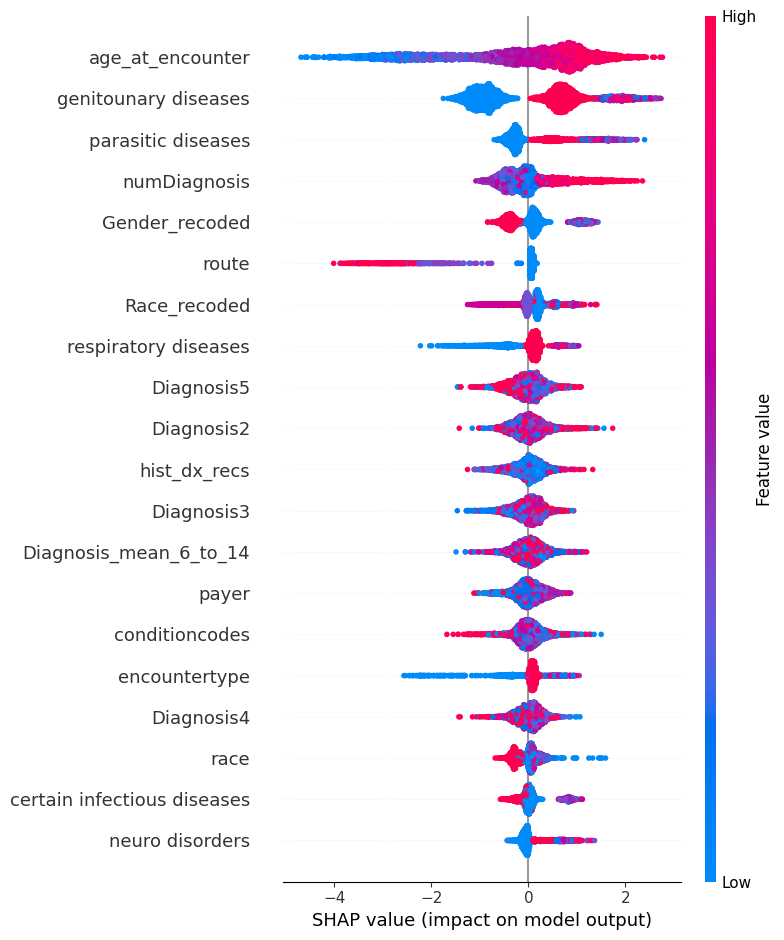

In [27]:
import pandas as pd
import xgboost as xgb
import shap
from sklearn.preprocessing import LabelEncoder

# Load and prepare the data
df = df_filtered

# Define features and target variable
X = df.drop(columns=['deceased'])
y = df['deceased'].astype(int)  # Ensure target is an integer

# Initialize a LabelEncoder
label_encoder = LabelEncoder()

# List of all categorical features including diagnosis columns
categorical_features = [
    'gender', 'race', 'ethnicity', 'source_encounter_type', 'conditioncodes',
    'encountertype', 'payer', 'admissiontype', 'Gender_recoded', 'Race_recoded', 'route',
    'Diagnosis1', 'Diagnosis2', 'Diagnosis3', 'Diagnosis4', 'Diagnosis5'
]

# Convert all categorical columns to integers using LabelEncoder
for col in categorical_features:
    if X[col].dtype == 'object' or X[col].dtype.name == 'category':
        X[col] = label_encoder.fit_transform(X[col])

# Define XGBoost model with GPU support
params = {
    'objective': 'binary:logistic',
    'tree_method': 'hist',
    'device': 'cuda',
    'predictor': 'gpu_predictor',
    'eval_metric': 'logloss'
}
dtrain = xgb.DMatrix(X, label=y)

# Train the model
model = xgb.train(params, dtrain, num_boost_round=100)

# SHAP values computation using the trained model
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Summary plot of SHAP values
shap.summary_plot(shap_values.values, X)

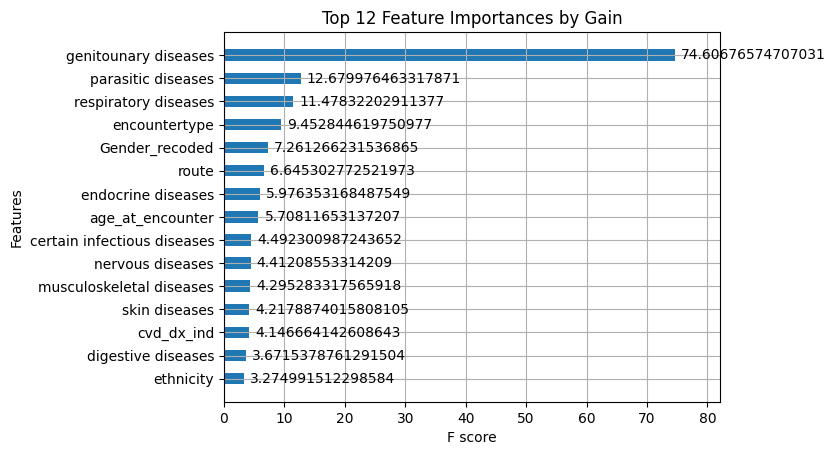

In [28]:
import matplotlib.pyplot as plt
# Plotting the feature importance
xgb.plot_importance(model, importance_type='gain', max_num_features=15, height=0.5)
plt.title('Top 12 Feature Importances by Gain')
plt.show()

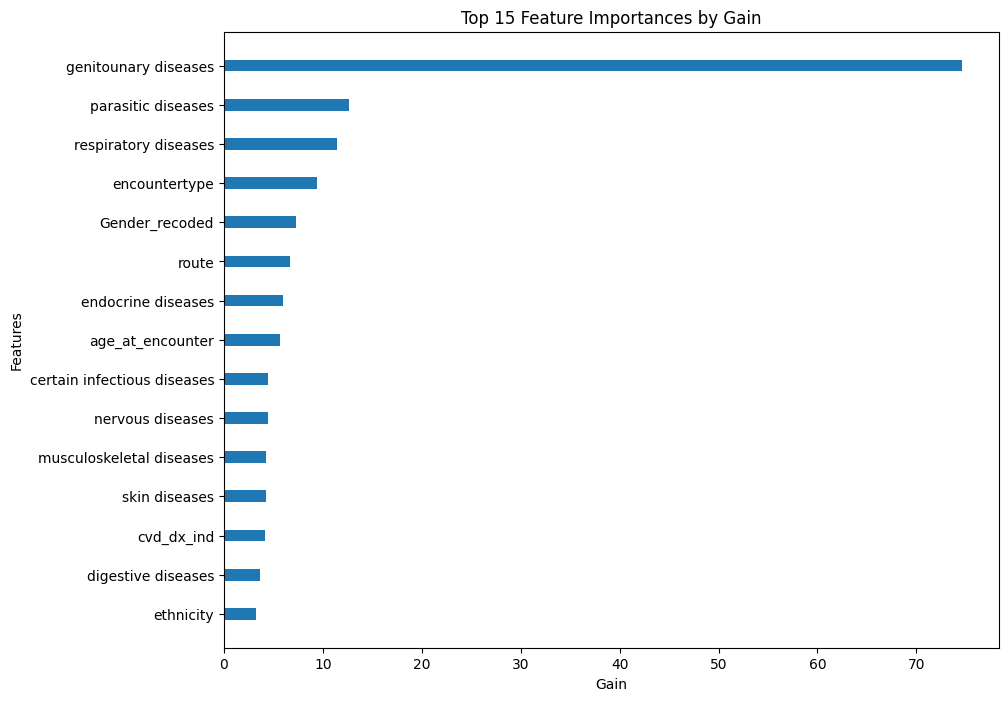

In [29]:
import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd

# Extract feature importance data
importance = model.get_score(importance_type='gain')
importance_df = pd.DataFrame({'Feature': list(importance.keys()), 'Gain': list(importance.values())})

# Round the gain values to 3 decimal places
importance_df['Gain'] = importance_df['Gain'].round(3)

# Sort the features by importance
importance_df = importance_df.sort_values(by='Gain', ascending=False).head(15)

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Gain'], height=0.3)
plt.xlabel('Gain')
plt.ylabel('Features')
plt.title('Top 15 Feature Importances by Gain')
plt.gca().invert_yaxis()  # To display the highest gain at the top
plt.show()

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

def compute_feature_importances_and_plot(df, target_column, n_splits=5):
    feature_importances = []

    # Use stratified sampling to maintain the same proportion of the target variable classes
    for i in range(n_splits):
        # Split the data - ensuring each split has the same proportion of target classes
        _, df_sampled = train_test_split(df, test_size=0.5, stratify=df[target_column], random_state=i)

        # Separate features and target
        X = df_sampled.drop(columns=[target_column])
        y = df_sampled[target_column]
        
        # Initialize a LabelEncoder
        label_encoder = LabelEncoder()

        # List of all categorical features including diagnosis columns
        categorical_features = ['gender', 'race', 'ethnicity', 'source_encounter_type', 'conditioncodes','encountertype', 'payer', 'admissiontype', 'Gender_recoded', 'Race_recoded', 'route','Diagnosis1', 'Diagnosis2', 'Diagnosis3', 'Diagnosis4', 'Diagnosis5']

        # Convert all categorical columns to integers using LabelEncoder
        for col in categorical_features:
            if X[col].dtype == 'object' or X[col].dtype.name == 'category':
                X[col] = label_encoder.fit_transform(X[col])

        # Initialize and fit the model
        model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
        model.fit(X, y)

        # Store feature importances
        importances = model.feature_importances_
        feature_importances.append(importances)

        # Plot feature importances for the current split
        plt.figure(figsize=(10, 6))
        indices = np.argsort(importances)[::-1]
        plt.title(f'Feature Importances for Split {i+1}')
        plt.bar(range(X.shape[1]), importances[indices], color="b", align="center")
        plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
        plt.xlim([-1, X.shape[1]])
        plt.ylabel('Importance')
        plt.show()

    # Calculate the average feature importances across all splits
    mean_importances = np.mean(feature_importances, axis=0)

    # Plot the average feature importances
    plt.figure(figsize=(10, 6))
    indices = np.argsort(mean_importances)[::-1]
    plt.title('Average Feature Importances Across All Splits')
    plt.bar(range(X.shape[1]), mean_importances[indices], color="r", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
    plt.xlim([-1, X.shape[1]])
    plt.ylabel('Average Importance')
    plt.show()

    # Return a DataFrame of feature importances sorted by mean importance
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': mean_importances
    }).sort_values(by='Importance', ascending=False)

    return importance_df

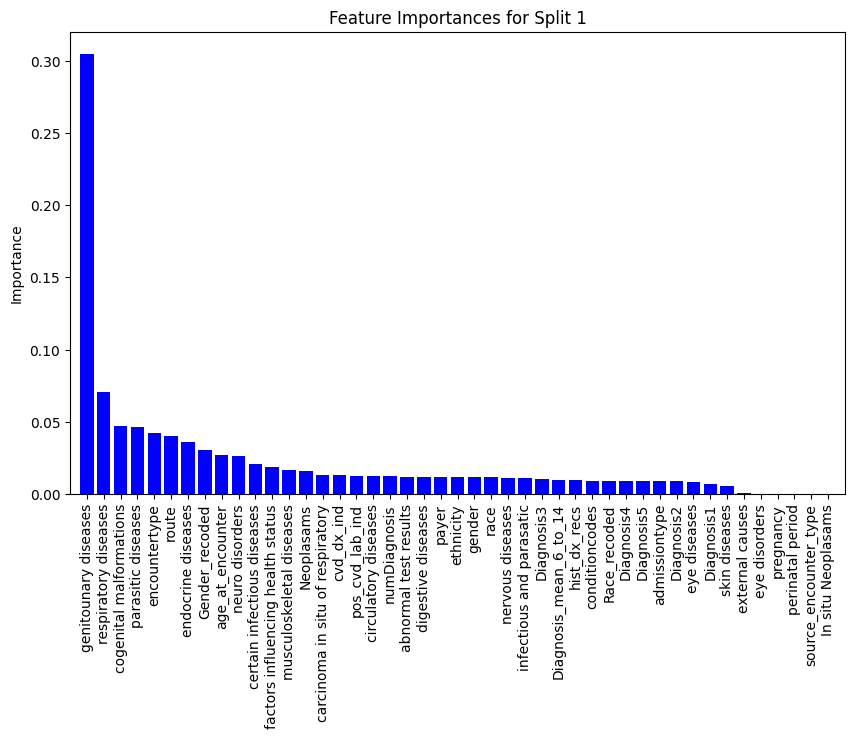

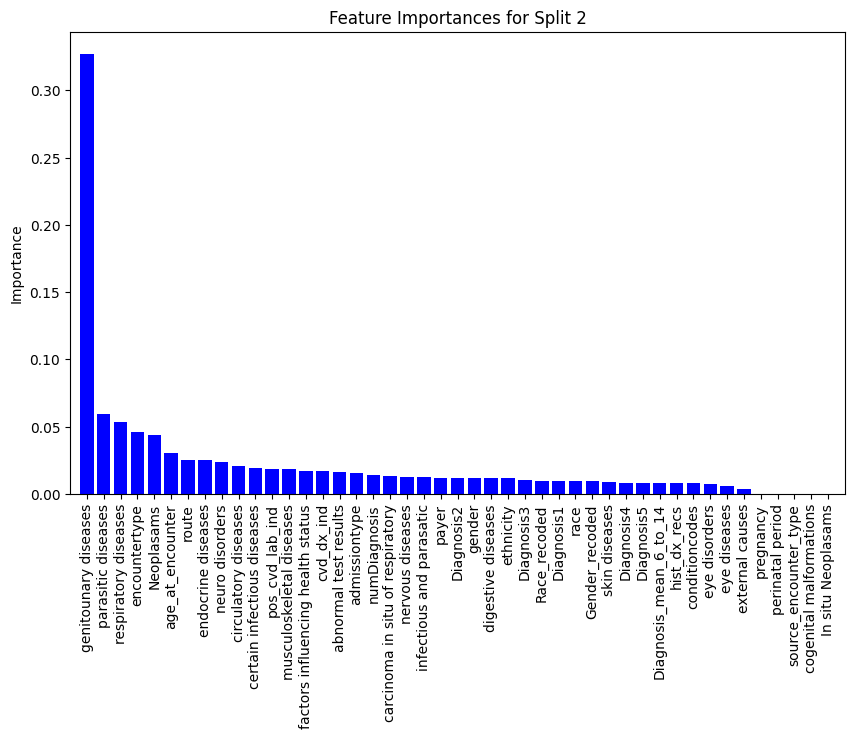

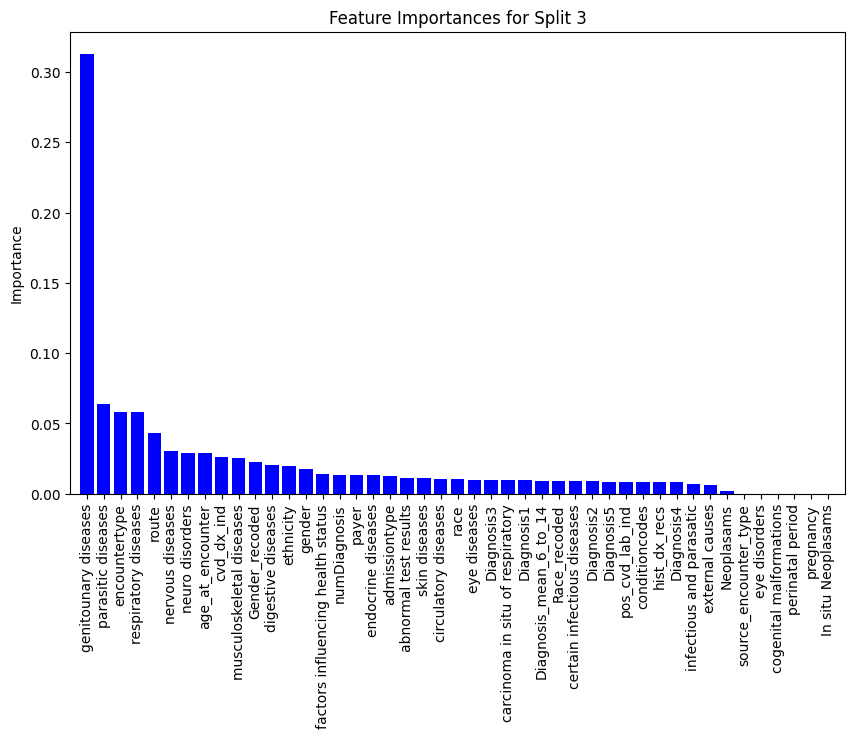

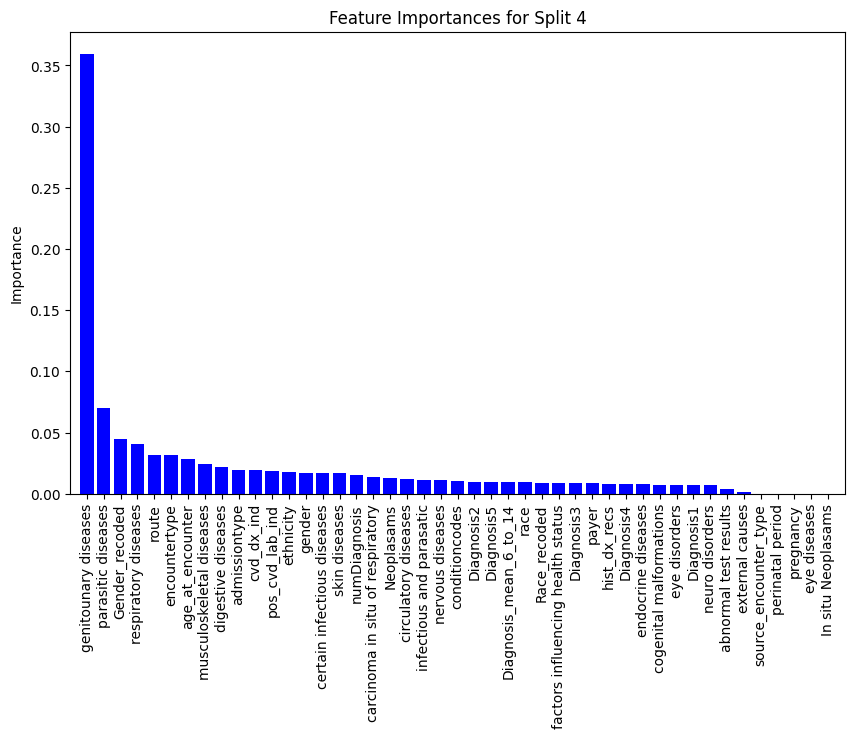

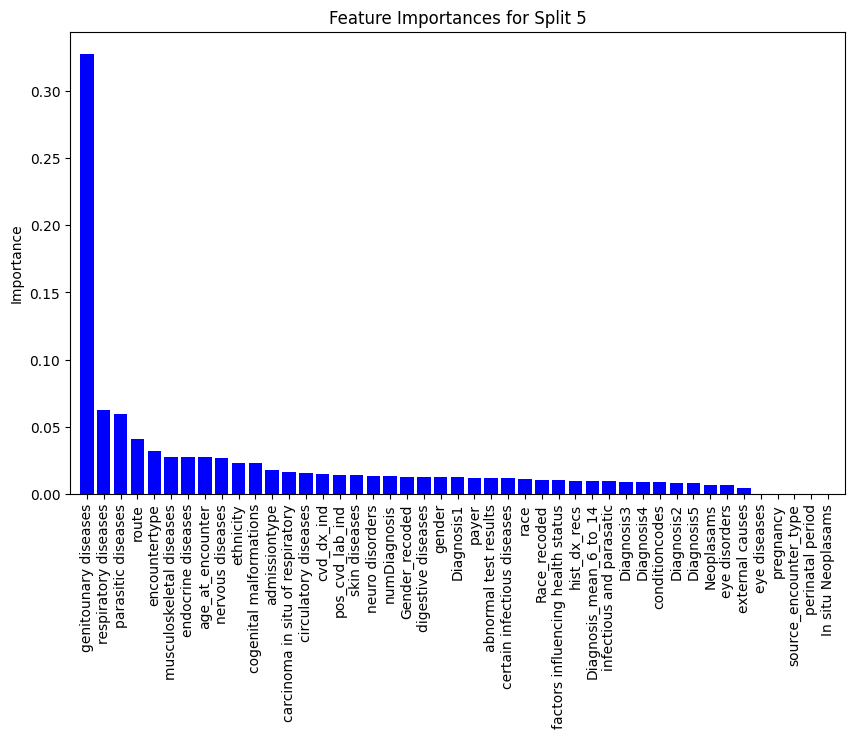

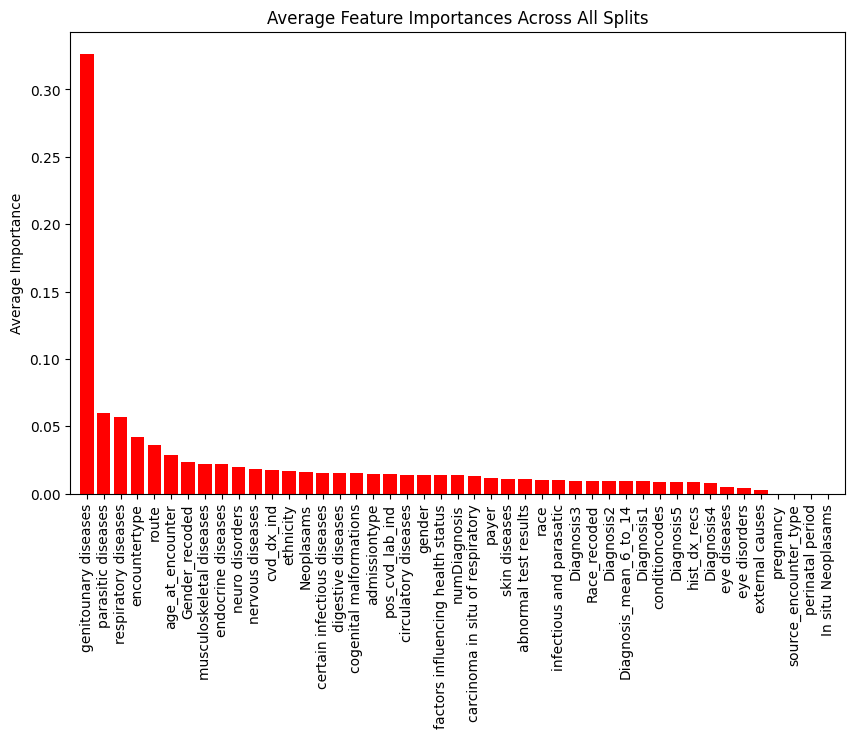

In [31]:
# Example usage
important_features_df = compute_feature_importances_and_plot(df_filtered, 'deceased')

In [32]:
important_features_df[:10]

,Feature,Importance
34,genitounary diseases,0.326496
18,parasitic diseases,0.059974
30,respiratory diseases,0.057194
5,encountertype,0.042006
43,route,0.036374
6,age_at_encounter,0.028427
41,Gender_recoded,0.023811
33,musculoskeletal diseases,0.022448
24,endocrine diseases,0.021944
25,neuro disorders,0.019960


In [33]:
# Filter the DataFrame to keep only rows with 'Importance' greater than 0.01
filtered_features_df = important_features_df[important_features_df['Importance'] > 0.015]

# Extract the list of features from the filtered DataFrame
important_feature_list = filtered_features_df['Feature'].tolist()

important_feature_list.append('deceased')

# Print the list of important features
print(important_feature_list)

['genitounary diseases', 'parasitic diseases', 'respiratory diseases', 'encountertype', 'route', 'age_at_encounter', 'Gender_recoded', 'musculoskeletal diseases', 'endocrine diseases', 'neuro disorders', 'nervous diseases', 'cvd_dx_ind', 'ethnicity', 'Neoplasams', 'certain infectious diseases', 'digestive diseases', 'cogenital malformations', 'deceased']


In [34]:
df_final = df_filtered[important_feature_list]

In [35]:
df_final.shape

(4516, 18)

In [36]:
# Convert DataFrame to a CSV file
df_final.to_csv('final_data_after_SHAP_splits.csv', index=False)

# Preliminary EDA

In [82]:
import seaborn as sns

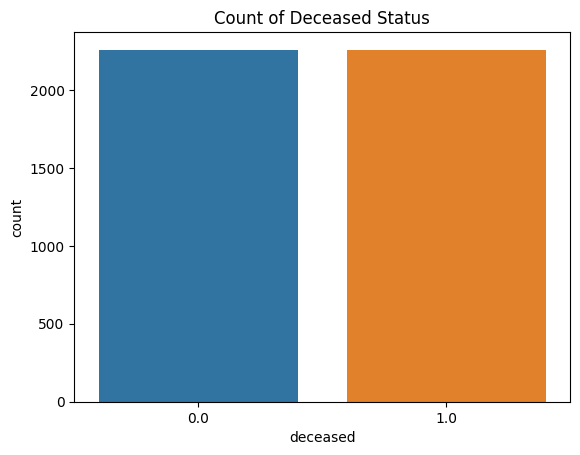

In [83]:
# 1. Count Plot of the Target Variable
sns.countplot(x='deceased', data=df_final)
plt.title('Count of Deceased Status')
plt.show()

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


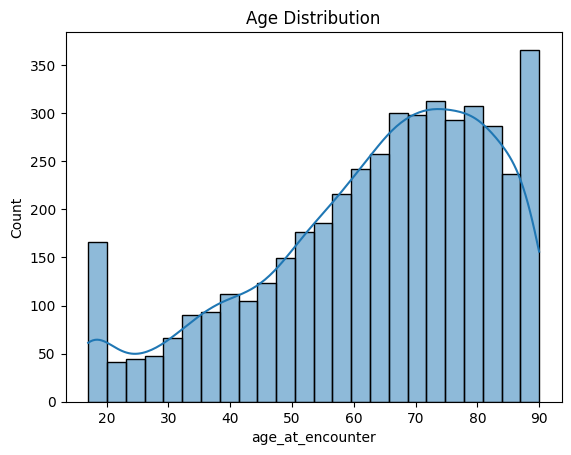

In [84]:
# 2. Histogram of Age
sns.histplot(x='age_at_encounter', data=df_final, kde=True)
plt.title('Age Distribution')
plt.show()

In [85]:
# 3. Bar Plot of Categorical Variables 
#sns.countplot(x='dischargedisposition_EXPIRED', data=df_final)
#plt.title('Counts of Discharge Disposition EXPIRED')
#plt.show()

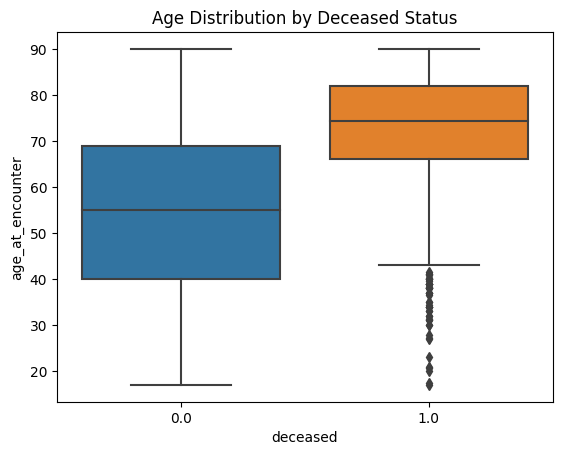

In [86]:
# 4. Box Plot of 'age_at_encounter' by 'deceased'
sns.boxplot(x='deceased', y='age_at_encounter', data=df_final)
plt.title('Age Distribution by Deceased Status')
plt.show()

In [90]:
df_final.describe()

,genitounary diseases,parasitic diseases,respiratory diseases,encountertype,route,age_at_encounter,Gender_recoded,musculoskeletal diseases,endocrine diseases,neuro disorders,nervous diseases,cvd_dx_ind,ethnicity,Neoplasams,certain infectious diseases,digestive diseases,cogenital malformations,deceased
count,4516.000000,4516.000000,4516.000000,4516.000000,4516.000000,4516.000000,4516.000000,4516.000000,4516.000000,4516.000000,4516.000000,4516.000000,4516.000000,4516.000000,4516.000000,4516.000000,4516.000000,4516.000000
mean,0.458471,0.236014,0.761259,1.752385,3.459822,63.464664,0.454559,0.117784,0.618947,0.216632,0.239183,0.798974,1.613389,0.044365,0.362442,0.174908,0.009615,0.500000
std,0.482649,0.402826,0.416062,0.479059,8.229192,18.756959,0.475558,0.308287,0.472129,0.390258,0.406058,0.387069,0.650563,0.194843,0.460848,0.361079,0.095612,0.500055
min,0.000000,0.000000,0.000000,0.000000,1.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.725930,2.000000,1.000000,52.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.041101,0.000000,1.000000,2.000000,1.000000,67.000000,0.155651,0.000000,1.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.500000
75%,1.000000,0.369857,1.000000,2.000000,1.000000,78.121794,1.000000,0.000000,1.000000,0.174128,0.386315,1.000000,2.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,3.000000,38.000000,90.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [91]:
df_final.shape

(4516, 18)

In [95]:
df_final.columns

Index(['genitounary diseases', 'parasitic diseases', 'respiratory diseases',
       'encountertype', 'route', 'age_at_encounter', 'Gender_recoded',
       'musculoskeletal diseases', 'endocrine diseases', 'neuro disorders',
       'nervous diseases', 'cvd_dx_ind', 'ethnicity', 'Neoplasams',
       'certain infectious diseases', 'digestive diseases',
       'cogenital malformations', 'deceased'],
      dtype='object')

In [96]:
# Confirm no more missing values
print(df_final.isnull().sum())

genitounary diseases           0
parasitic diseases             0
respiratory diseases           0
encountertype                  0
route                          0
age_at_encounter               0
Gender_recoded                 0
musculoskeletal diseases       0
endocrine diseases             0
neuro disorders                0
nervous diseases               0
cvd_dx_ind                     0
ethnicity                      0
Neoplasams                     0
certain infectious diseases    0
digestive diseases             0
cogenital malformations        0
deceased                       0
dtype: int64


# Data Modeling using 
1. Logistic Regression
2. RandomForest
3. Catboost
4. Xgboost
5. LightGBM

## All 5 models

In [98]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Assuming df_final is your DataFrame and 'deceased' is the target variable
target = 'deceased'
X = df_final.drop(columns=[target])
y = df_final[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define the models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier()
}

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score)
}

# Evaluate each model using cross-validation on the training set
results = {}
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    scores = {metric: cross_val_score(model, X_train, y_train, scoring=scorer, cv=cv).mean()
              for metric, scorer in scoring.items()}
    results[model_name] = scores

# Display results
results_df = pd.DataFrame(results).T
results_df = results_df[['accuracy', 'f1', 'roc_auc', 'precision', 'recall']]
print("Cross-Validation Results on Training Set:")
print(results_df)

# Train each model on the entire training set and evaluate on the test set
final_results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    final_results[model_name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred)
    }

# Display final results on the test set
final_results_df = pd.DataFrame(final_results).T
print("Final Results on Test Set:")
print(final_results_df)

Evaluating Logistic Regression...
Evaluating Random Forest...
Evaluating CatBoost...
Evaluating XGBoost...
Evaluating LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1445, number of negative: 1444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 2889, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500173 -> initscore=0.000692
[LightGBM] [Info] Start training from score 0.000692
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1444, number of negative: 1445
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.